In [19]:
import sys
from pathlib import Path
# point Python at the project `src/` tree so imports work
ROOT = Path().resolve().parents[0]
sys.path.append(str(ROOT / "src"))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd

plt.style.use("rotskoff_notebook.mplstyle")

In [20]:
MICROSTATES = ["APP", "BPP", "CPP", "DPP", "PPP"]
DATA_ROOT = ROOT / "data" / "microstates"

datasets = {}
carbon_datasets = {}
hydro_datasets = {}
all_carbon_datasets = {}

for state in MICROSTATES:
    base = DATA_ROOT / state
    npz = np.load(base / "rawESP" / "charges.npz", allow_pickle=True)
    labels = npz["labels"].astype(str)
    charges = npz["charges"]

    mask_no = np.char.startswith(labels, "N") | np.char.startswith(labels, "O")
    mask_h = np.char.startswith(labels, "H") 
    mask_c = np.array([lbl.startswith("C") and len(lbl) > 1 and lbl[1].isdigit()
                       for lbl in labels])
    mask_allC = np.char.startswith(labels, "C")

    cluster_weights = np.loadtxt(base / "weights.dat", usecols=1)
    weights = np.concatenate([np.full(500, w) for w in cluster_weights])
    assert weights.shape[0] == charges.shape[1], f"weight mismatch for {state}"

    datasets[state] = {
        "labels": labels[mask_no],
        "charges": charges[mask_no],
        "weights": weights,
    }
    carbon_datasets[state] = {
        "labels": labels[mask_c],
        "charges": charges[mask_c],
        "weights": weights,
    }
    hydro_datasets[state] = {
        "labels": labels[mask_h],
        "charges": charges[mask_h],
        "weights": weights,
    }
    all_carbon_datasets[state] = {
        "labels": labels[mask_allC],
        "charges": charges[mask_allC],
        "weights": weights,
    }

Text(0.02, 0.5, 'Cluster-weighted norm. histograms')

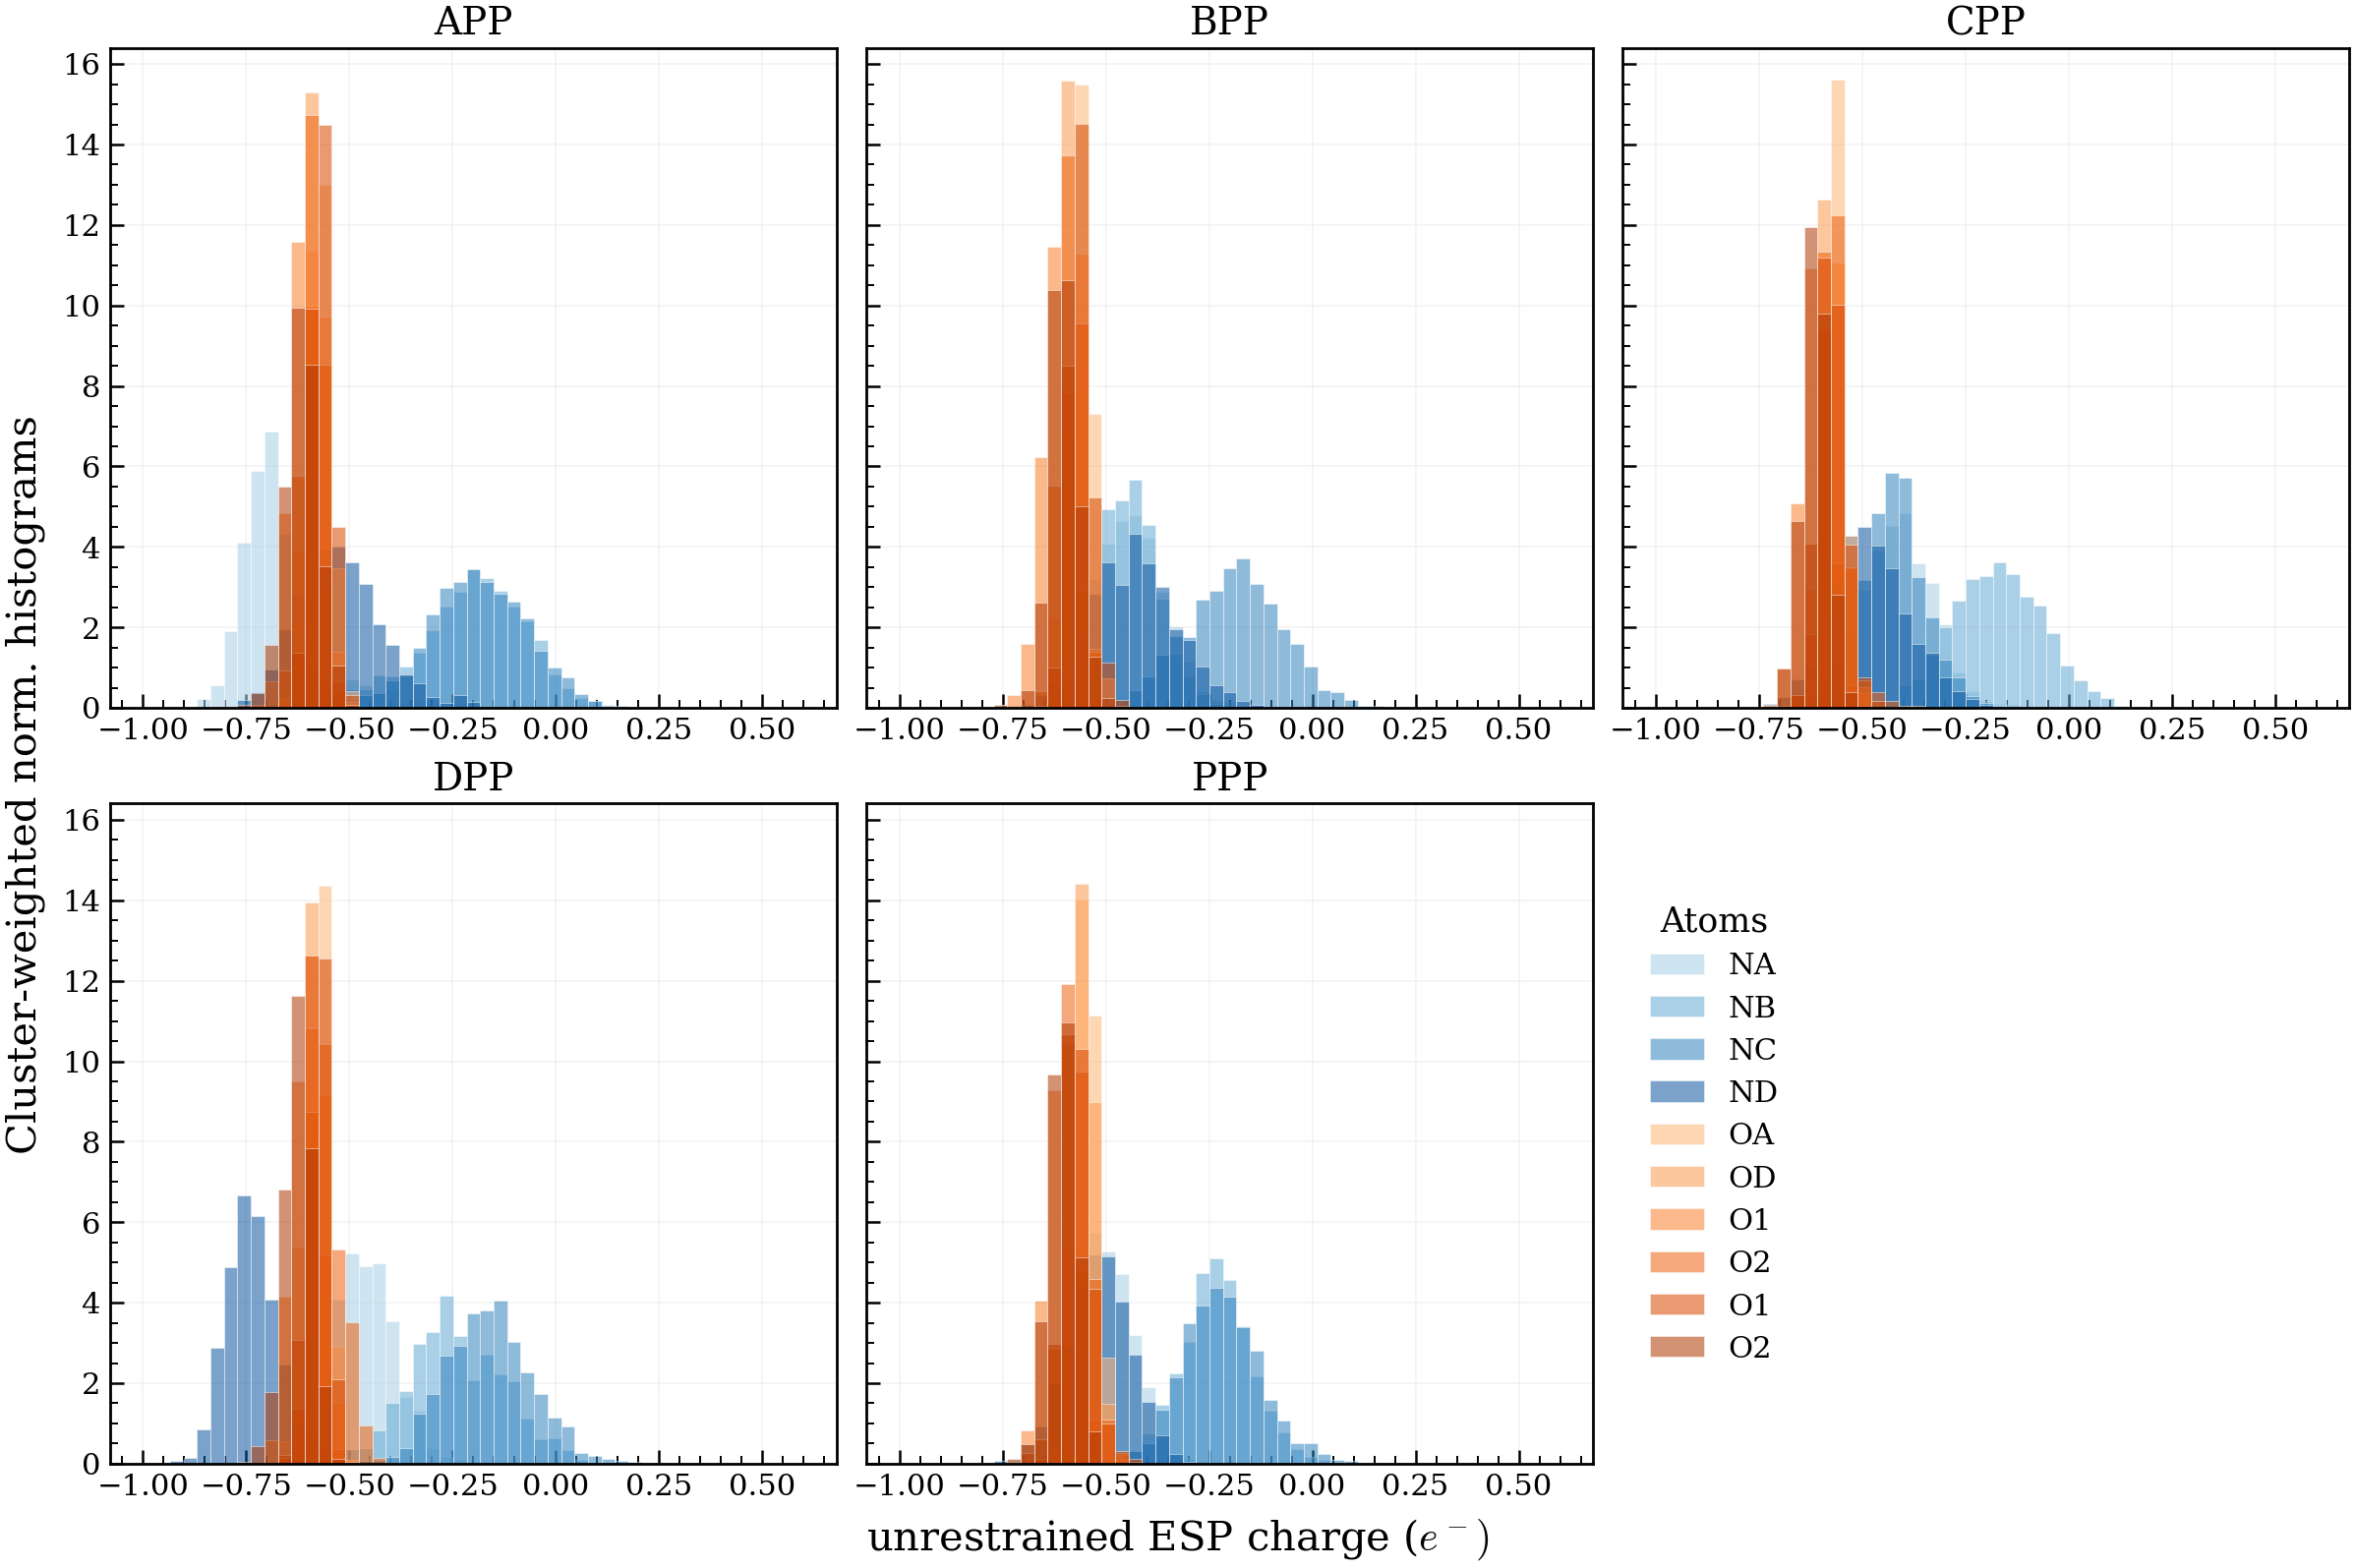

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=False, sharey=True)
axes = axes.ravel()
bins = np.linspace(-1.0, 0.6, 50)

legend_handles, legend_labels = [], []
collect_legend = True

for ax, state in zip(axes[:-1], MICROSTATES):
    labels = datasets[state]["labels"]
    charges = datasets[state]["charges"]
    weights = datasets[state]["weights"]
    unweights = np.ones_like(datasets[state]["weights"], dtype=float)

    n_idx = [i for i, lbl in enumerate(labels) if lbl.startswith("N")]
    o_idx = [i for i, lbl in enumerate(labels) if lbl.startswith("O")]

    blues = plt.cm.Blues(np.linspace(0.35, 0.85, len(n_idx))) if n_idx else []
    oranges = plt.cm.Oranges(np.linspace(0.35, 0.85, len(o_idx))) if o_idx else []

    ax.set_title(state)
    ax.grid(alpha=0.3)

    for color, idx in zip(blues, n_idx):
        series = charges[idx]
        _, _, patches = ax.hist(
            series, bins=bins, density=True,
            alpha=0.55, color=color, edgecolor="white",
            linewidth=0.3, label=labels[idx], weights=weights,
        )
        if collect_legend:
            legend_handles.append(patches[0])
            legend_labels.append(labels[idx])

    for color, idx in zip(oranges, o_idx):
        series = charges[idx]
        _, _, patches = ax.hist(
            series, bins=bins, density=True,
            alpha=0.55, color=color, edgecolor="white",
            linewidth=0.3, label=labels[idx], weights=weights,
        )
        if collect_legend:
            legend_handles.append(patches[0])
            legend_labels.append(labels[idx])

    collect_legend = False

# dedicate the sixth subplot to a legend
legend_ax = axes[-1]
legend_ax.axis("off")
legend_ax.legend(legend_handles, legend_labels,
                 loc="center left", frameon=False, title="Atoms")

fig.supxlabel(r"unrestrained ESP charge ($e^-)$")
fig.supylabel("Cluster-weighted norm. histograms")
#fig.tight_layout()

Text(0.02, 0.5, 'Cluster-weighted norm. histograms')

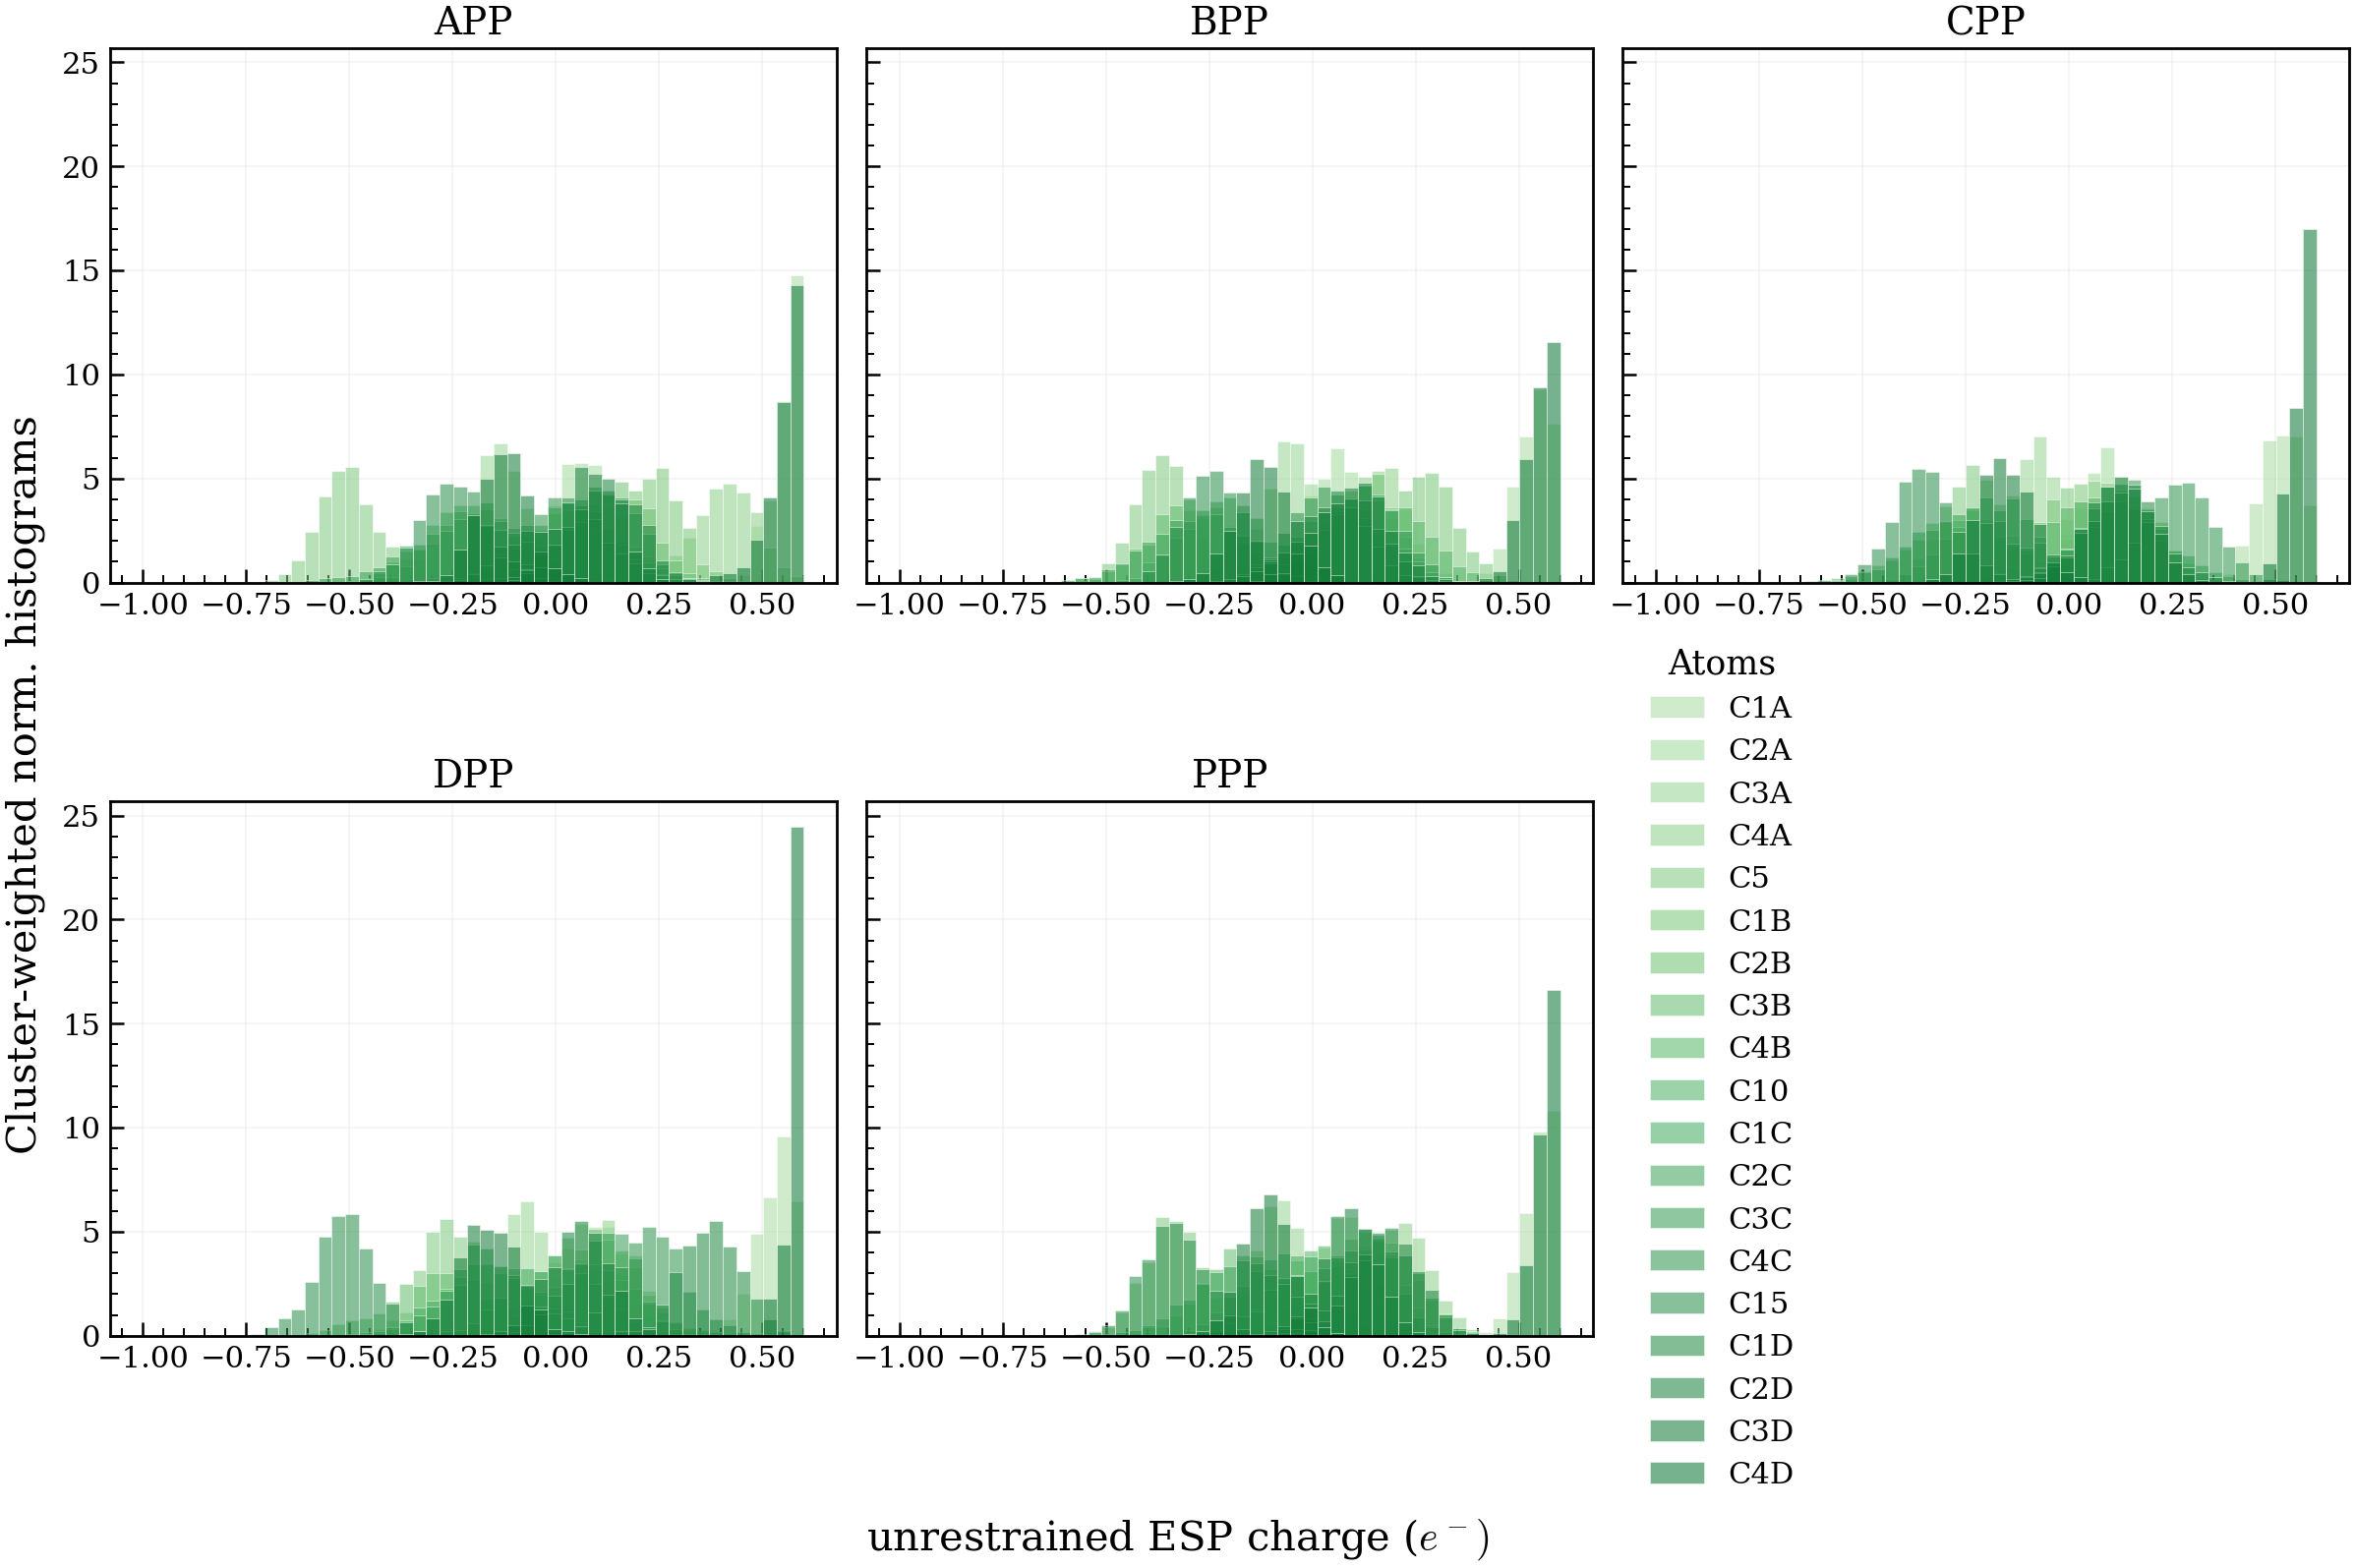

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=False, sharey=True)
axes = axes.ravel()
bins = np.linspace(-1.0, 0.6, 50)

legend_handles, legend_labels = [], []
collect_legend = True

for ax, state in zip(axes[:-1], MICROSTATES):
    labels = carbon_datasets[state]["labels"]
    charges = carbon_datasets[state]["charges"]
    weights = carbon_datasets[state]["weights"]

    c_idx = range(len(labels))
    greens = plt.cm.Greens(np.linspace(0.35, 0.85, len(c_idx))) if labels.size else []

    ax.set_title(state)
    ax.grid(alpha=0.3)

    for color, idx in zip(greens, c_idx):
        series = charges[idx]
        _, _, patches = ax.hist(
            series,
            bins=bins,
            density=True,
            weights=weights,
            alpha=0.55,
            color=color,
            edgecolor="white",
            linewidth=0.3,
            label=labels[idx],
        )
        if collect_legend:
            legend_handles.append(patches[0])
            legend_labels.append(labels[idx])

    collect_legend = False

legend_ax = axes[-1]
legend_ax.axis("off")
legend_ax.legend(legend_handles, legend_labels,
                 loc="center left", frameon=False, title="Atoms")

fig.supxlabel(r"unrestrained ESP charge ($e^-)$")
fig.supylabel("Cluster-weighted norm. histograms")

Text(0.02, 0.5, 'Cluster-weighted norm. histograms')

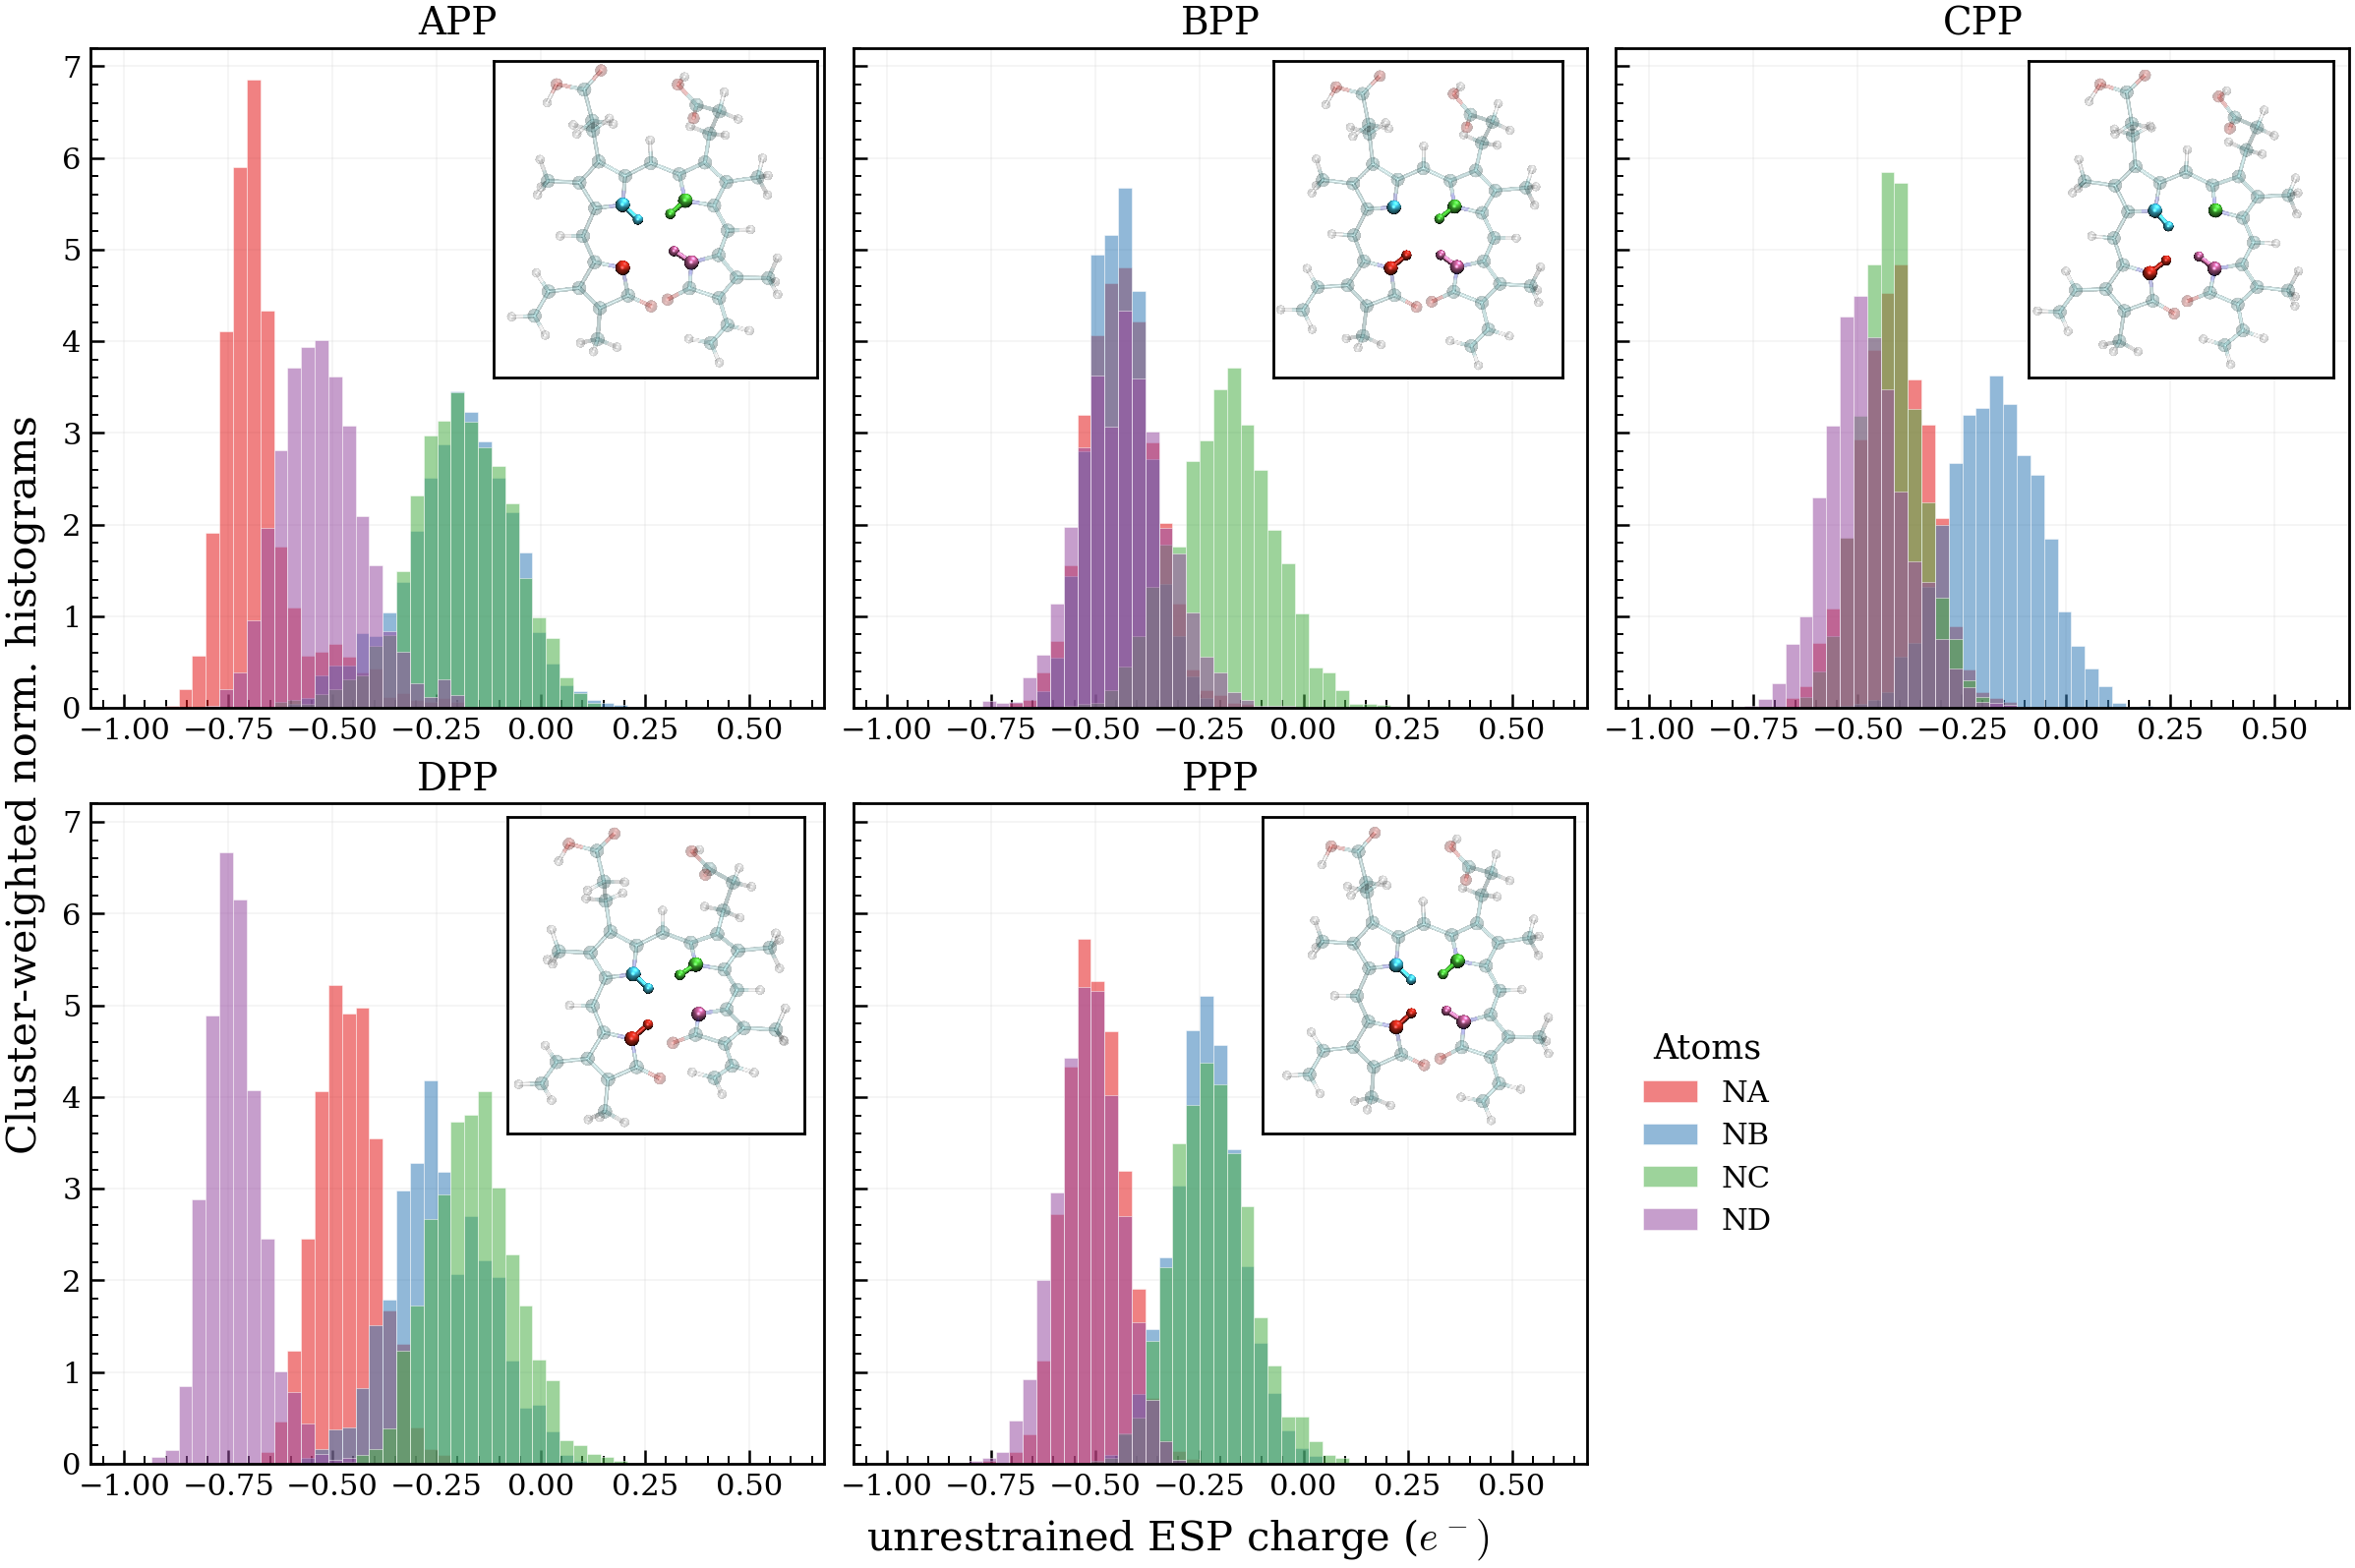

In [23]:
# Build a global color map once
all_labels = sorted({lbl for data in datasets.values() for lbl in data["labels"]})
palette = plt.get_cmap("Set1")              # qualitative, high-contrast palette
colors = [palette(i / max(1, len(all_labels) - 1)) for i in range(len(all_labels))]
color_map = dict(zip(all_labels, colors))


fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=False, sharey=True)
axes = axes.ravel()
bins = np.linspace(-1.0, 0.6, 50)

legend_handles, legend_labels = [], []
collect_legend = True

for ax, state in zip(axes[:-1], MICROSTATES):
    labels = datasets[state]["labels"]
    charges = datasets[state]["charges"]
    weights = datasets[state]["weights"]
    img_path = DATA_ROOT / state / "screenshot.png"
    ax.set_title(state)
    ax.grid(alpha=0.3)


    img = mpimg.imread(img_path)
    inset = ax.inset_axes([0.53, 0.50, 0.48, 0.48], transform=ax.transAxes)
    inset.imshow(img)
    inset.set_xticks([])
    inset.set_yticks([])

    for spine in inset.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor("black")
        spine.set_linewidth(1)
    
    for label, series in zip(labels, charges):
        if not label.startswith("N"):
            continue

        color = color_map.get(label, "#333333")
        _, _, patches = ax.hist(
            series,
            bins=bins,
            density=True,
            weights=weights,
            alpha=0.55,
            color=color,
            edgecolor="white",
            linewidth=0.3,
            label=label,
        )
        if collect_legend:
            legend_handles.append(patches[0])
            legend_labels.append(label)

    collect_legend = False

legend_ax = axes[-1]
legend_ax.axis("off")
legend_ax.legend(legend_handles, legend_labels,
                 loc="center left", frameon=False, title="Atoms")

fig.supxlabel(r"unrestrained ESP charge ($e^-)$")
fig.supylabel("Cluster-weighted norm. histograms")


Text(0.02, 0.5, 'Cluster-weighted norm. histograms')

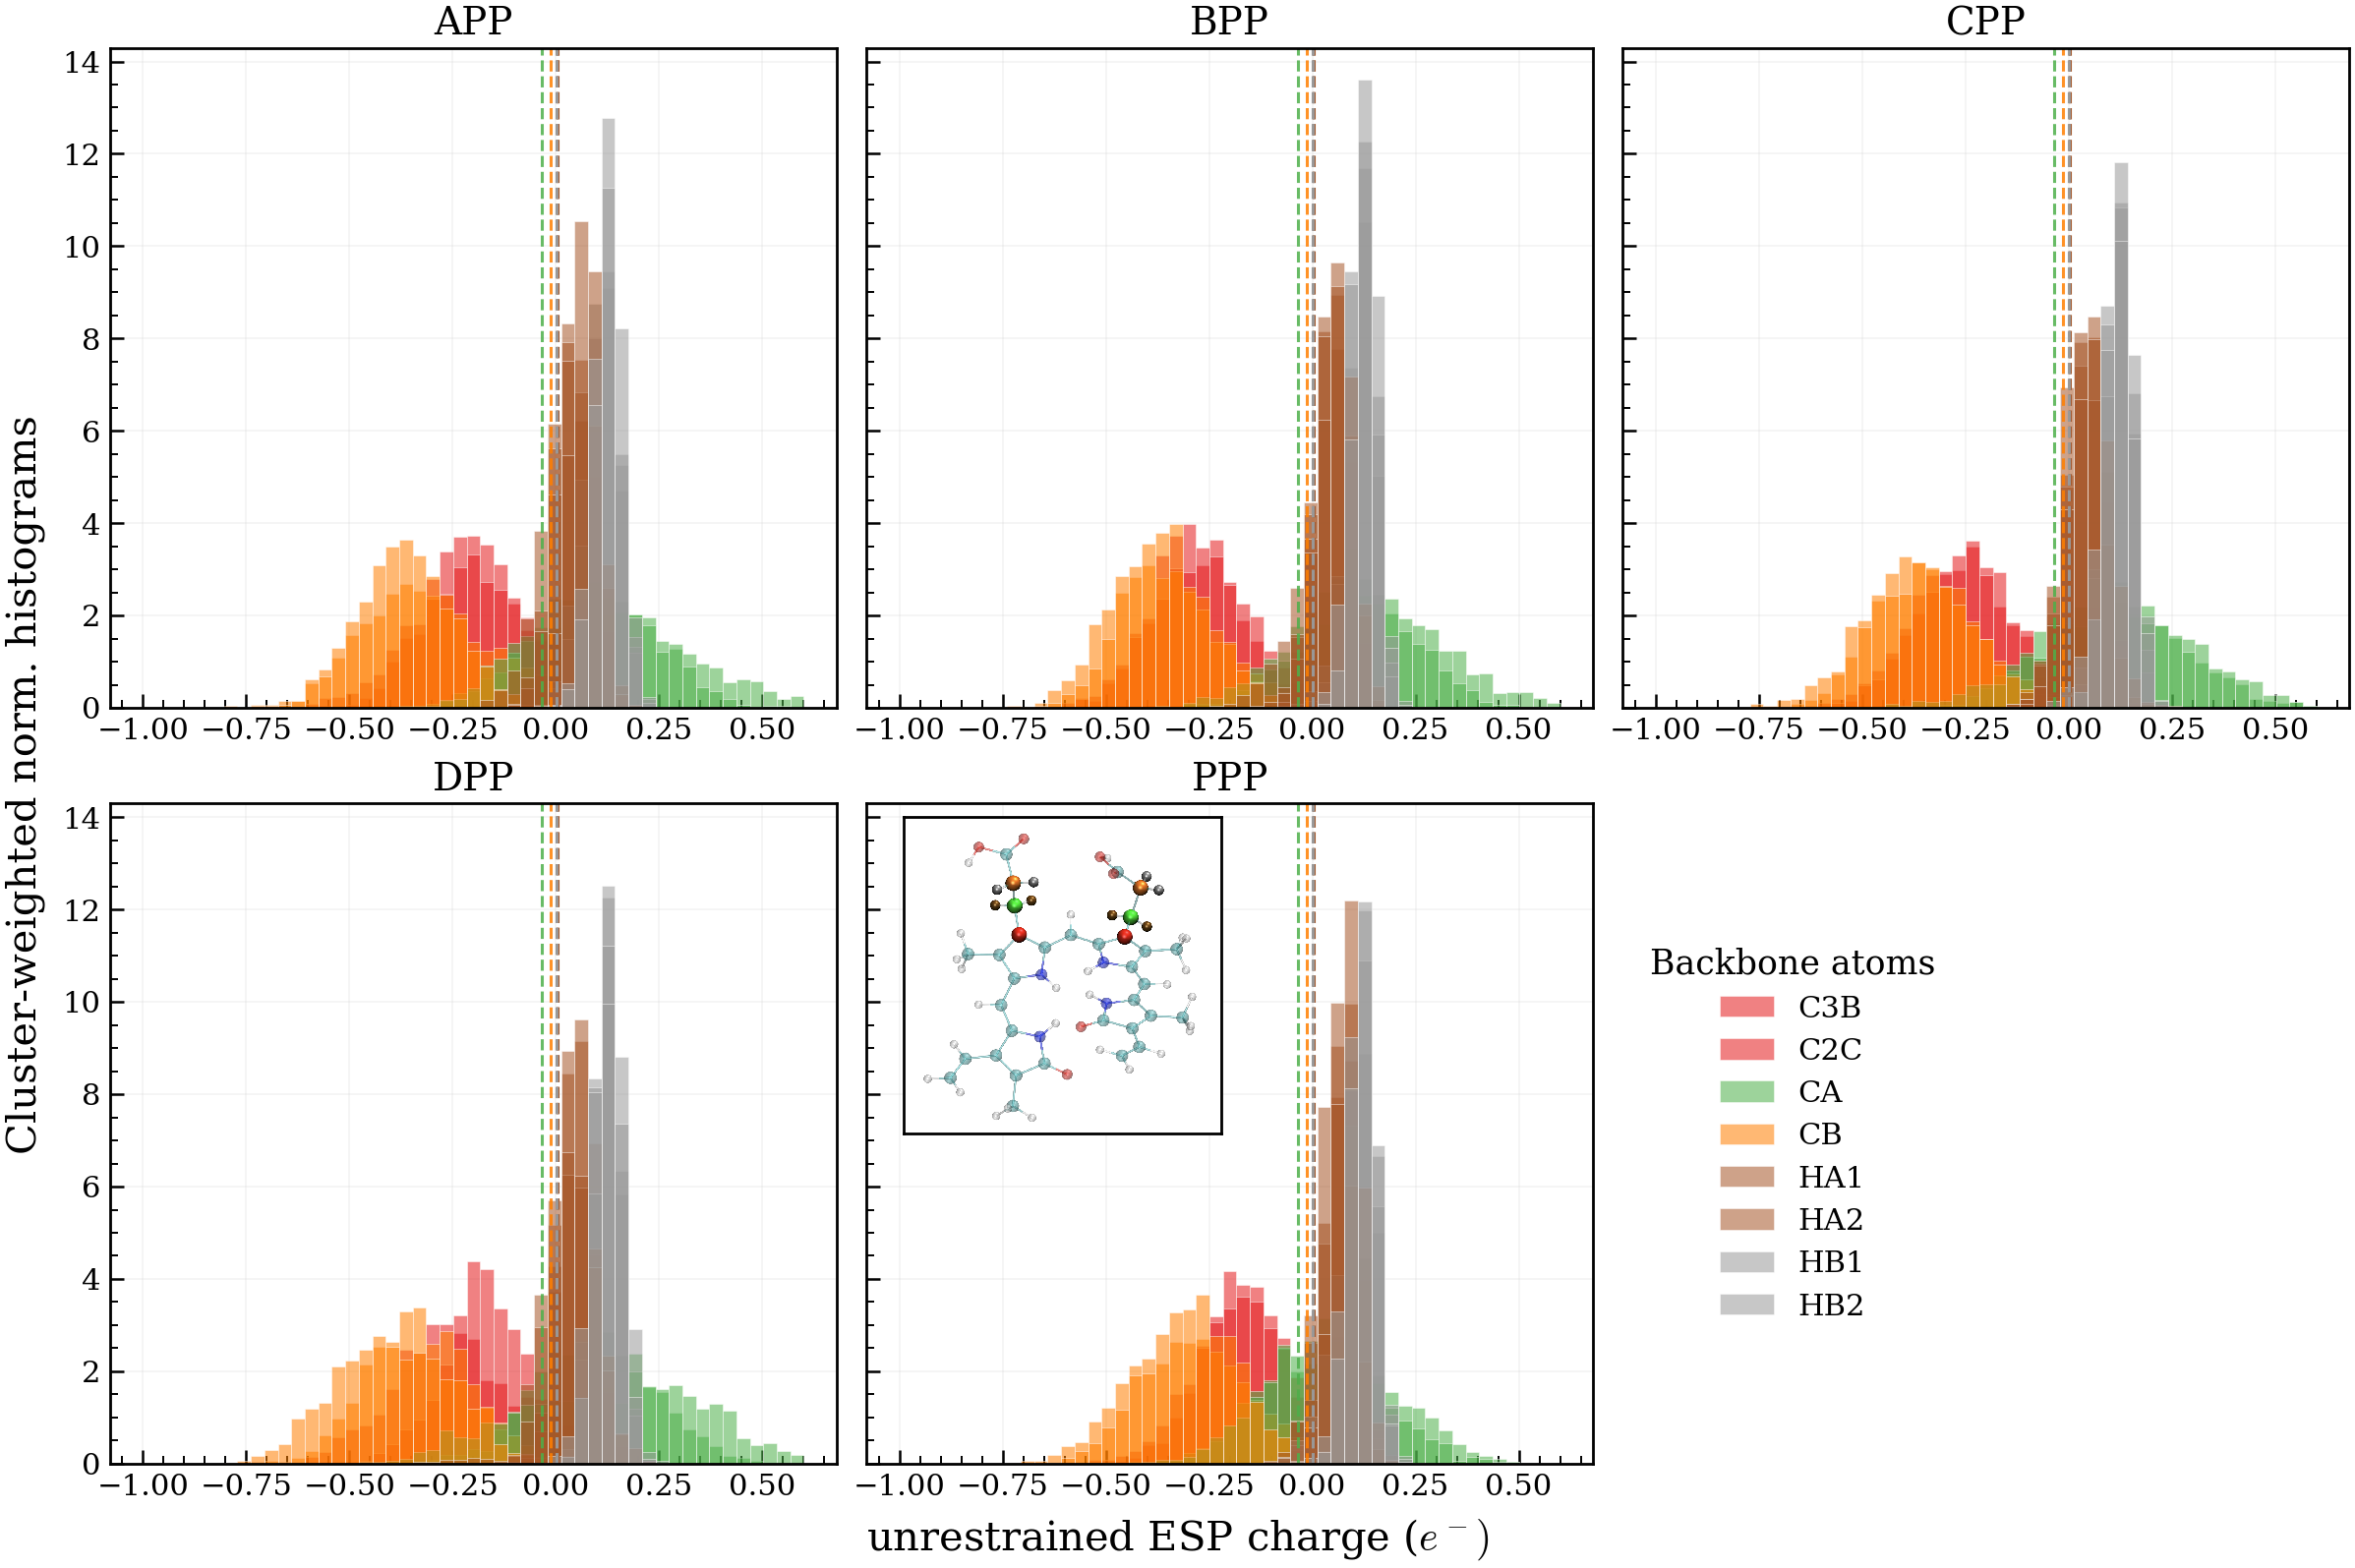

In [28]:
BACKBONE_ATOMS = ['C3B', 'C2C', 'CA', 'HA1', 'HA2', 'CB', 'HB1', 'HB2']
LINE_VALUES = {
    'CA':  -0.03445,
    'HA1':  0.00415,
    'HA2':  0.00415,
    'CB':  -0.01290,
    'HB1':  0.00025,
    'HB2':  0.00025,
}

COLOR_GROUP = {
    'C3B': 'C3B/C2C',
    'C2C': 'C3B/C2C',
    'HA1': 'HA1/HA2',
    'HA2': 'HA1/HA2',
    'HB1': 'HB1/HB2',
    'HB2': 'HB1/HB2',
}

def color_key(label):
    return COLOR_GROUP.get(label, label)

def merge_labels_and_series(state):
    pairs = []
    pairs.extend(zip(all_carbon_datasets[state]["labels"],
                     all_carbon_datasets[state]["charges"]))
    pairs.extend(zip(hydro_datasets[state]["labels"],
                     hydro_datasets[state]["charges"]))
    weights = carbon_datasets[state]["weights"]
    return pairs, weights

palette = plt.get_cmap("Set1")
# Build color map once for any label we’ll color (histogram lines or reference lines)
present_keys = sorted({
    color_key(lbl)
    for state in MICROSTATES
    for lbl in (
        list(carbon_datasets[state]["labels"]) +
        list(hydro_datasets[state]["labels"])
    )
    if lbl in BACKBONE_ATOMS
}.union({color_key(lbl) for lbl in LINE_VALUES}))
colors = [palette(i / max(1, len(present_keys) - 1)) for i in range(len(present_keys))]
color_map = dict(zip(present_keys, colors))
DEFAULT_COLOR = "#333333"

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=False, sharey=True)
axes = axes.ravel()
bins = np.linspace(-1.0, 0.6, 50)

legend_handles, legend_labels = [], []
collect_legend = True

for ax, state in zip(axes[:-1], MICROSTATES):
    label_series_pairs, weights = merge_labels_and_series(state)
    img_path = DATA_ROOT / state / "tail.png"

    ax.set_title(state)
    ax.grid(alpha=0.3)
    
    if state == "PPP":
        img = mpimg.imread(img_path)
        inset = ax.inset_axes([0.03, 0.50, 0.48, 0.48], transform=ax.transAxes)
        inset.imshow(img)
        inset.set_xticks([])
        inset.set_yticks([])
        for spine in inset.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor("black")
            spine.set_linewidth(1)

    for label, series in label_series_pairs:
        if label not in BACKBONE_ATOMS:
            continue

        color = color_map[color_key(label)]
        _, _, patches = ax.hist(
            series,
            bins=bins,
            density=True,
            weights=weights,
            alpha=0.55,
            color=color,
            edgecolor="white",
            linewidth=0.3,
            label=label,
        )
        if collect_legend and label not in legend_labels:
            legend_handles.append(patches[0])
            legend_labels.append(label)

    for label, x in LINE_VALUES.items():
        if label in BACKBONE_ATOMS:
            ax.axvline(
                x,
                color=color_map[color_key(label)],
                linestyle="--",
                linewidth=1.1,
                alpha=0.85,
            )

    collect_legend = False

legend_ax = axes[-1]
legend_ax.axis("off")
legend_ax.legend(
    legend_handles,
    legend_labels,
    loc="center left",
    frameon=False,
    title="Backbone atoms",
)

fig.supxlabel(r"unrestrained ESP charge ($e^-)$")
fig.supylabel("Cluster-weighted norm. histograms")
